In [1]:
using PyPlot, LinearAlgebra, Random

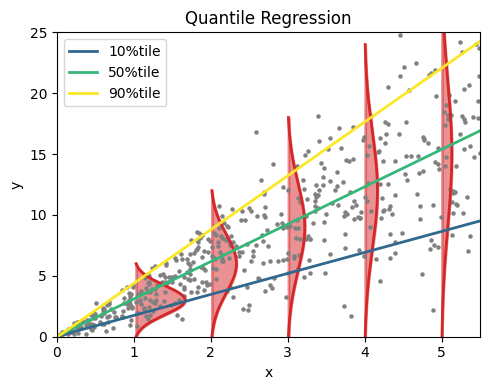

In [2]:
function QuantileGradientDescent(X, y, initθ, τ; lr=1e-4, num_iters=10000)
    θ = initθ
    for i in 1:num_iters
        ŷ = X * θ # predictions
        δ = y - ŷ  # error
        grad = abs.(τ .- 1.0(δ .<= 0.)) .* sign.(δ) # gradient
        θ += lr * X' * grad # Update
    end
    return θ
end;

function gaussian_func(x, μ, σ)
    return 0.8/σ*exp(-(x -μ)^2/(2σ^2))
end;

# Generate Toy datas
N = 500 # sample size
x = sort(5.5rand(N))
y = 3x + x .* randn(N);
X = ones(N, 2) # design matrix
X[:, 2] = x;
τs = [0.1, 0.5, 0.9]
m = length(τs) 
Ŷ = zeros(m, N); # memory array
for i in 1:m
    initθ = zeros(2) # init variables
    θ = QuantileGradientDescent(X, y, initθ, τs[i])
    Ŷ[i, :] = X * θ
end

# Results plot
figure(figsize=(5,4))
title("Quantile Regression")
for loc in 1:5
    ξy = 0:1e-3:6loc
    ξx = loc .+ gaussian_func.(ξy, 3loc, 1.2loc)
    fill_between(ξx, -1, ξy, color="tab:red", linewidth=2, alpha=0.5)
    plot(ξx, ξy, color="tab:red", linewidth=2)
end
cmvir = get_cmap(:viridis)
for i in 1:m
    plot(x, Ŷ[i, :], linewidth=2, label=string(Int(τs[i]*100))*"%tile", color=cmvir(i/m)) # regression line
end
scatter(x, y, color="gray", s=5) # samples
xlabel("x"); ylabel("y")
xlim(0, 5.5); ylim(0, 25); legend()
tight_layout()

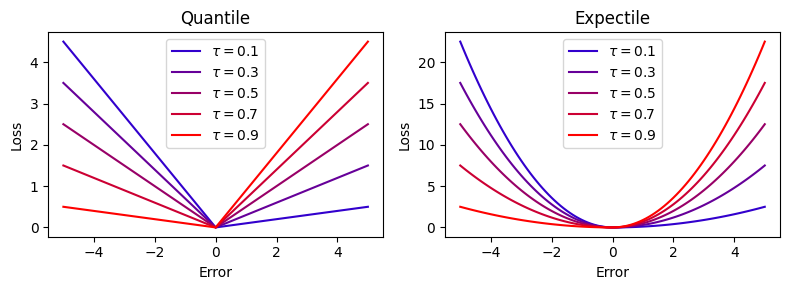

In [3]:
δ = -5:0.1:5
τ= 0.1:0.2:0.9
cmbrg = get_cmap(:brg) 
figure(figsize=(8,3))
subplot(1,2,1)
title("Quantile")
for i in 1:length(τ)
    indic = 1.0(δ .<= 0)
    z = (τ[i] .- indic) .* δ
    plot(δ, z, color=cmbrg(0.5i/length(τ)), label=L"$\tau=$"*string(τ[i]))
end
xlabel("Error"); ylabel("Loss")
legend(); tight_layout()

subplot(1,2,2)
title("Expectile")
for i in 1:length(τ)
    indic = 1.0(δ .<= 0)
    z = abs.(τ[i] .- indic) .* δ.^2
    plot(δ, z, color=cmbrg(0.5i/length(τ)), label=L"$\tau=$"*string(τ[i]))
end
xlabel("Error"); ylabel("Loss")
legend(); tight_layout()

In [4]:
function QuantileGradientDescent(X, y, initθ, τ; lr=0.1, num_iters=10000)
    θ = initθ
    for i in 1:num_iters
        ŷ = X * θ # predictions
        δ = y - ŷ  # error
        grad = abs.(τ .- 1.0(δ .<= 0.)) .* sign.(δ) # gradient
        θ += lr * X' * grad # Update
    end
    return θ
end

function ExpectileGradientDescent(X, y, initθ, τ; lr=0.1, num_iters=10000)
    θ = initθ
    for i in 1:num_iters
        ŷ = X * θ # predictions
        δ = y - ŷ  # error
        grad = 2*abs.(τ .- 1.0(δ .<= 0.)) .* δ # gradient
        θ += lr * X' * grad # Update
    end
    return θ
end;

In [5]:
# Generate Toy datas
num_train, num_test = 100, 500 # sample size
dims = 4 # dimensions
Random.seed!(0);

x = rand(num_train) #range(0.1, 0.9, length=num_train)
y =  sin.(2π*x) + 0.3randn(num_train);
X = hcat([x .^ p for p in 0:dims-1]...); # design matrix

xtest = range(0, 1, length=num_test)
Xtest =hcat([xtest .^ p for p in 0:dims-1]...);

In [6]:
τs = [0.01, 0.1, 0.5, 0.9, 0.99]
m = length(τs) 

# Quantile regression
initθ = zeros(dims)
Ŷq = zeros(m, num_test); # memory array
for i in 1:m
    θq = QuantileGradientDescent(X, y, initθ, τs[i], lr=1e-2, num_iters=1e5)
    Ŷq[i, :] = Xtest * θq
end


# Expectile regression
initθ = zeros(dims)
Ŷe = zeros(m, num_test); # memory array
for i in 1:m
    θe = ExpectileGradientDescent(X, y, initθ, τs[i], lr=1e-2, num_iters=1e5)
    Ŷe[i, :] = Xtest * θe
end

In [7]:
normal_equation(Xtest, X, y) = Xtest * ((X' * X) \ X' * y)

normal_equation (generic function with 1 method)

In [8]:
ŷ = normal_equation(Xtest, X, y); # predictions

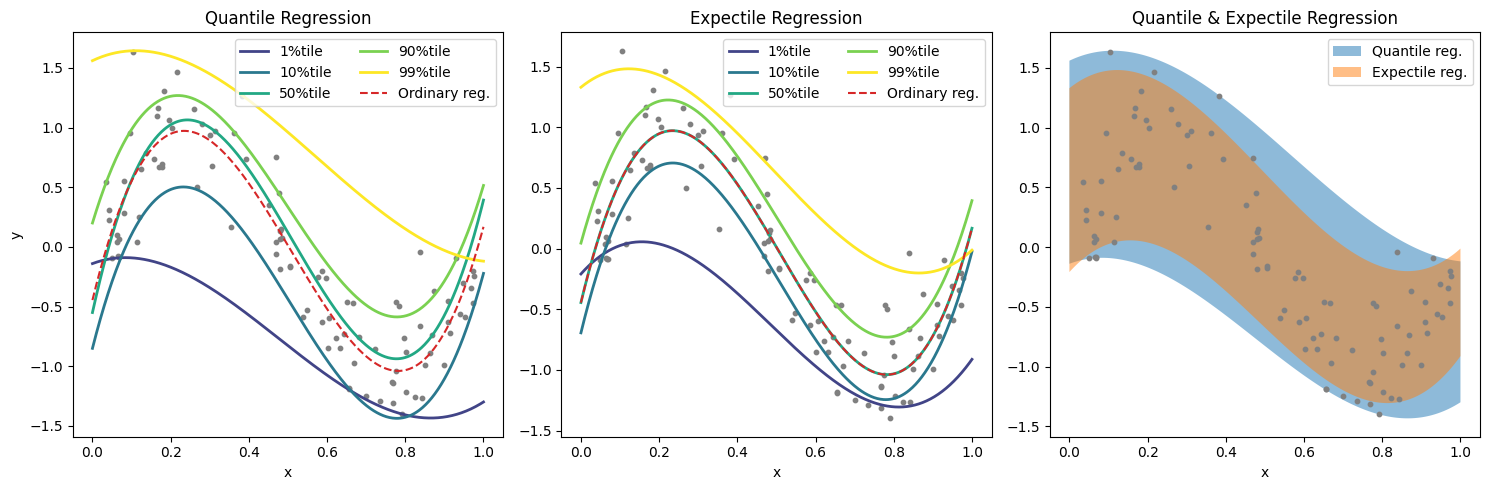

In [9]:
# Results plot
figure(figsize=(15,5), dpi=100)
subplot(1,3,1)
title("Quantile Regression")
cm = get_cmap(:viridis)
for i in 1:m
    plot(xtest, Ŷq[i, :], linewidth=2, label=string(Int(τs[i]*100))*"%tile", color=cm(i/m)) # regression line
end
plot(xtest, ŷ, color="tab:red",  "--", label="Ordinary reg.")  # regression line
scatter(x, y, color="gray", s=10) # samples
xlabel("x"); ylabel("y"); legend(ncol=2)

# Results plot
subplot(1,3,2)
title("Expectile Regression")
cm = get_cmap(:viridis)
for i in 1:m
    plot(xtest, Ŷe[i, :], linewidth=2, label=string(Int(τs[i]*100))*"%tile", color=cm(i/m)) # regression line
end
plot(xtest, ŷ, color="tab:red", "--", label="Ordinary reg.")  # regression line
scatter(x, y, color="gray", s=10) # samples
xlabel("x"); legend(ncol=2)

subplot(1,3,3)
title("Quantile & Expectile Regression")
fill_between(xtest, Ŷq[1, :], Ŷq[end, :], alpha=0.5, label="Quantile reg.")
fill_between(xtest, Ŷe[1, :], Ŷe[end, :], alpha=0.5, label="Expectile reg.")
scatter(x, y, color="gray", s=10) # samples
xlabel("x"); legend()
tight_layout()